In [1]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/df_indi_works_occupations.csv", index_col=0)

regions = pd.read_csv('../data/ENS - Cultural Index - Countries Databases - region_level.csv')
regions['region_name'][regions['region_name']=='Slav world'] = 'East Slavic'


regions = regions[regions['level'] == 2]
regions = regions[regions['region_name']!='Eastern Europe']
regions = regions[regions['region_name']!='Balkans']
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]

df["century"] = df["decade"].round(-2)
df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]

#df = df[df['decade']>=1800]

df['count'] = df['count_works']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})] # Not more ?
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})

# about 6% of women compared to men
df_m = df_m[df_m['decade']<1870]

df_base = df_m.copy()
df_base = df_base.drop('occupation', axis=1).drop_duplicates()

list(set(df.region_name))



WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_38230/2254136367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions['region_name'][regions['region_name']=='Slav world'] = 'East Slavic'


['Low countries',
 'Greek World',
 'France',
 'Indian world',
 'Persian world',
 'Latin World',
 'Korea',
 'Italy',
 'Arabic world',
 'Spain',
 'United Kingdom',
 'German world',
 'Portugal',
 'East Slavic',
 'Japan',
 'Central Europe',
 'Nordic countries',
 'Chinese world']

In [51]:
df

,individual_wikidata_id,decade,region_name,count_works,occupation,century,count
0,Q496891,1570,Korea,0.0,Written work,1600,0.0
4,Q5163563,1800,France,6.0,Work of art,1800,6.0
8,Q21289814,1840,United Kingdom,1.0,Work of art,1800,1.0
12,Q3568446,1870,France,0.0,Architecture,1900,0.0
16,Q21289660,1850,United Kingdom,0.0,Work of art,1800,0.0
...,...,...,...,...,...,...,...
542174,Q95212340,1870,Central Europe,0.0,Written work,1900,0.0
542176,Q44915481,1870,German world,2.0,Work of art,1900,2.0
542183,Q22960713,1740,United Kingdom,0.0,Written work,1700,0.0
542186,Q78064636,1770,German world,0.0,Science,1800,0.0


In [48]:
df_test = df[['individual_wikidata_id', 'region_name', 'decade']].drop_duplicates()
max(df_test[df_test['region_name']=='Greek World'].decade)

df_filtered = df_test[df_test['individual_wikidata_id'].map(df_test['individual_wikidata_id'].value_counts()) >= 2]

,individual_wikidata_id,decade,region_name,count_works,occupation,century,count
0,Q496891,1570,Korea,0.0,Written work,1600,0.0
4,Q5163563,1800,France,6.0,Work of art,1800,6.0
8,Q21289814,1840,United Kingdom,1.0,Work of art,1800,1.0
12,Q3568446,1870,France,0.0,Architecture,1900,0.0
16,Q21289660,1850,United Kingdom,0.0,Work of art,1800,0.0
...,...,...,...,...,...,...,...
542174,Q95212340,1870,Central Europe,0.0,Written work,1900,0.0
542176,Q44915481,1870,German world,2.0,Work of art,1900,2.0
542183,Q22960713,1740,United Kingdom,0.0,Written work,1700,0.0
542186,Q78064636,1770,German world,0.0,Science,1800,0.0


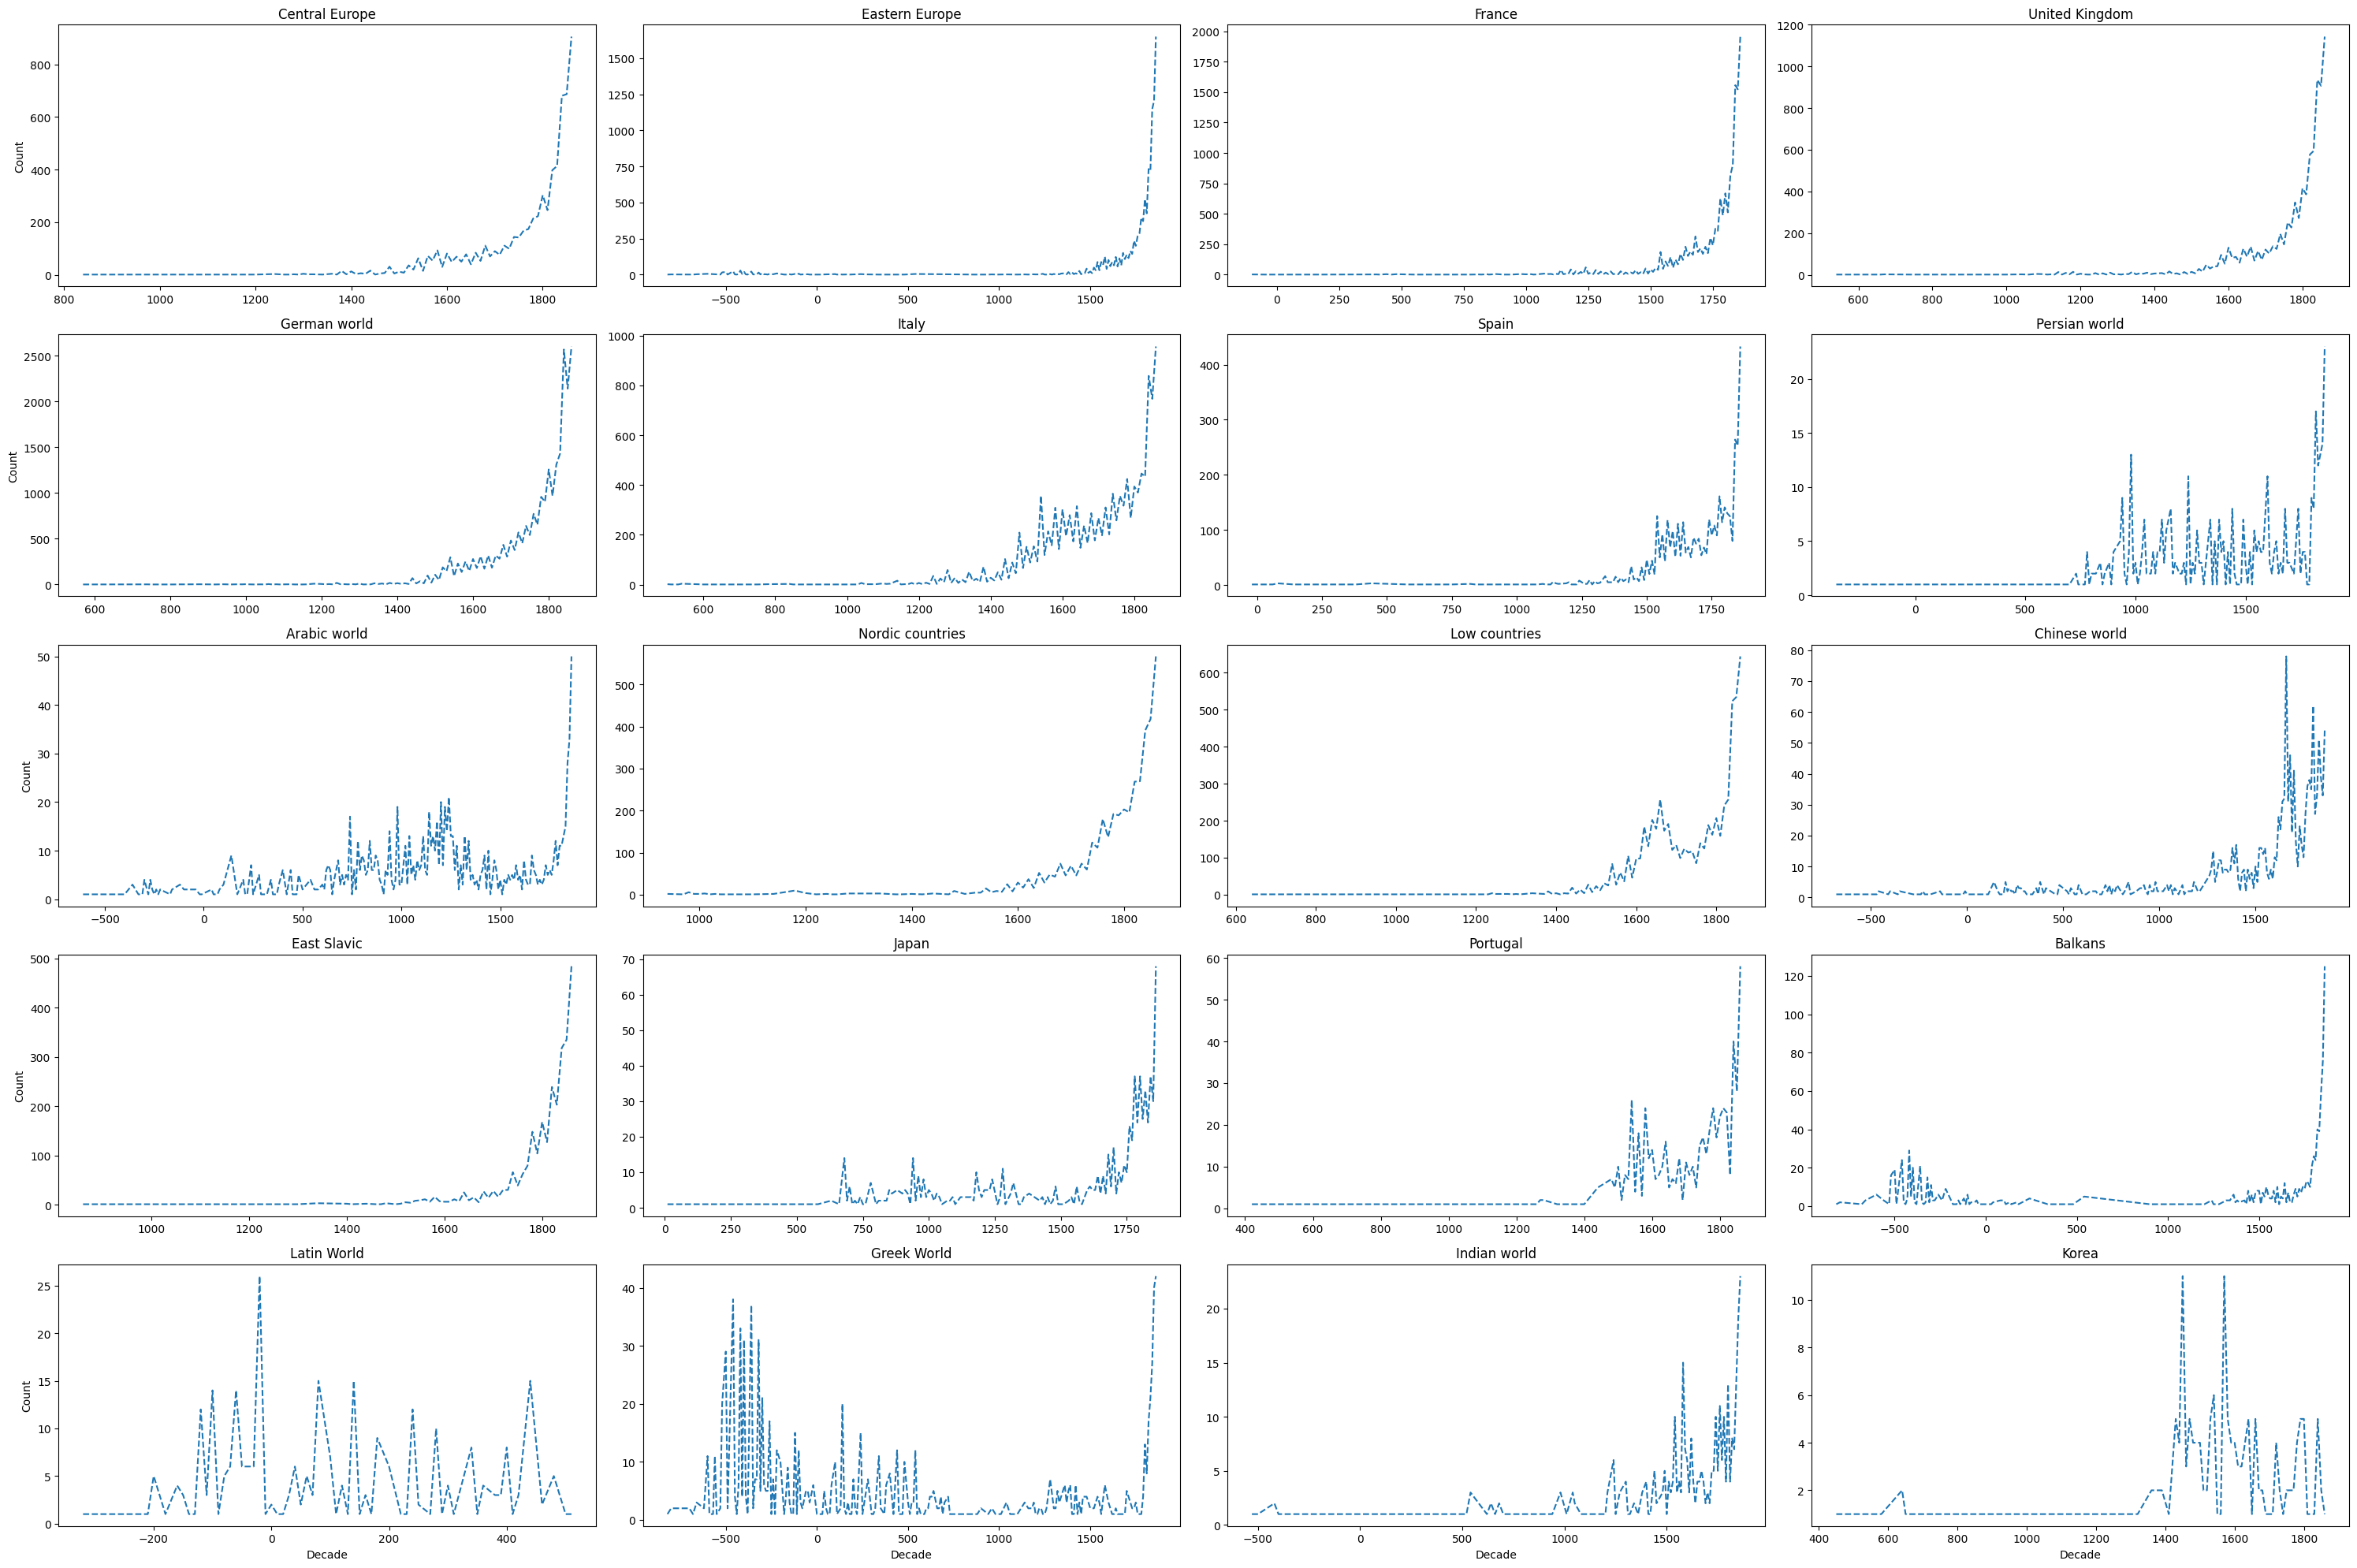

In [6]:
# Get unique regions
unique_regions = df_base["region_name"].unique()

# Calculate number of rows and columns for subplots
num_rows = 5
num_cols = 4

# Calculate total number of subplots needed
num_plots = len(unique_regions)

# Calculate figure size
fig_width = 30  # Adjust this as needed
fig_height = num_rows * 4  # Adjust this as needed

# Create figure and axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Flatten the axes array to easily iterate over them
axs = axs.flatten()

# Iterate over each region
for i, region in enumerate(unique_regions):
    # Get the current axis
    ax = axs[i]
    
    # Filter data for the current region
    region_data = df_base[df_base["region_name"] == region]
    
    # Group by decade and gender, count individual_wikidata_id, and unstack
    grouped_data = region_data.groupby("decade")["individual_wikidata_id"].count()
    
    # Plot the data
    grouped_data.plot(ax=ax, ls="--")
    
    # Set title for the subplot
    ax.set_title(region)
    
    # Hide x-axis label for all but the bottom row
    if i // num_cols != num_rows - 1:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Decade')
    
    # Hide y-axis label for all but the leftmost column
    if i % num_cols != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
# knots
num_knots = 10
knots = np.linspace(df_base["century"].min(), df_base["century"].max(), num_knots)
iknots = knots[1:-1]

df_occupation_sample = df_m.copy().sample(10000, random_state=42)
df_base_sample = df_occupation_sample.drop('occupation', axis=1).drop_duplicates()

,individual_wikidata_id,decade,region_name,count_works,century,count,y
379670,Q3836995,1840,Italy,0.0,1800,0.0,0
253440,Q28016715,1830,Eastern Europe,0.0,1800,0.0,0
29239,Q3256852,1440,Chinese world,1.0,1400,1.0,0
336025,Q2900133,1830,Italy,0.0,1800,0.0,0
22626,Q5698430,1660,Spain,1.0,1700,1.0,0
...,...,...,...,...,...,...,...
248917,Q6238531,1790,Nordic countries,1.0,1800,1.0,0
244869,Q55626478,1840,Central Europe,0.0,1800,0.0,0
432292,Q754748,1840,France,0.0,1800,0.0,0
76334,Q16321011,-420,Balkans,0.0,-400,0.0,0


In [9]:
# SECOND MODEL
priors_base_model = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    df_base_sample[['decade','region_name', 'y']], 
    family='bernoulli', 
    priors=priors_base_model)

base_model_fitted = base_model.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True}

) 
# important to run faster and sample more efficiently

Modeling the probability that y==1


Compiling...
2024-03-07 19:47:44.691487: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:02.871043
Sampling...
sample: 100%|██████████| 2000/2000 [00:48<00:00, 41.58it/s, 63 steps of size 7.02e-02. acc. prob=0.9

In [24]:


def get_unseen_numbers(df, model, model_fitted, region = 'Chinese world'):

    new_data = {}

    data = df[df["region_name"] == region]
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    new_data = pd.DataFrame(new_data)
    model.predict(model_fitted, data=new_data)
    posterior_stacked = az.extract(model_fitted)

    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    N_est = np.zeros((len(decades), f0.shape[1]))

    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di
        N_est[i] = S_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1)

    table = []
    table.append(pd.DataFrame({
        "N_est": N_est.mean(1),
        "lower": hdi_data[0],
        "upper": hdi_data[1],
        "decade": decades,
        "region_name": [region] * N_est.shape[0]
    }))
    table = pd.concat(table)

    return table

table = get_unseen_numbers(df_base_sample, base_model, base_model_fitted, region = 'Greek World')

from tqdm import tqdm
final_table = []
for region in tqdm(df_base_sample.region_name.unique()):
    table = get_unseen_numbers(df_base_sample, base_model, base_model_fitted, region = region)
    final_table.append(table)

df_final_table = pd.concat([x for x in final_table])

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


In [26]:
df_count = df_base_sample.groupby(['region_name', 'decade'])['individual_wikidata_id'].count().reset_index()

df_unseen = pd.merge(df_final_table, df_count, on = ['region_name', 'decade'])
df_unseen

,N_est,lower,upper,decade,region_name,individual_wikidata_id
0,4.492551,2.834658,6.421901,880,Italy,1
1,5.323052,3.291214,7.740059,1040,Italy,1
2,5.425626,3.399423,7.794381,1060,Italy,1
3,11.485087,7.743005,15.741128,1120,Italy,2
4,11.723382,8.080968,15.879698,1140,Italy,2
...,...,...,...,...,...,...
940,4.377478,2.228682,7.030500,340,Latin World,1
941,4.398946,2.150304,7.283944,380,Latin World,1
942,4.399185,2.136167,7.281017,390,Latin World,1
943,8.702313,4.280943,14.366007,440,Latin World,2


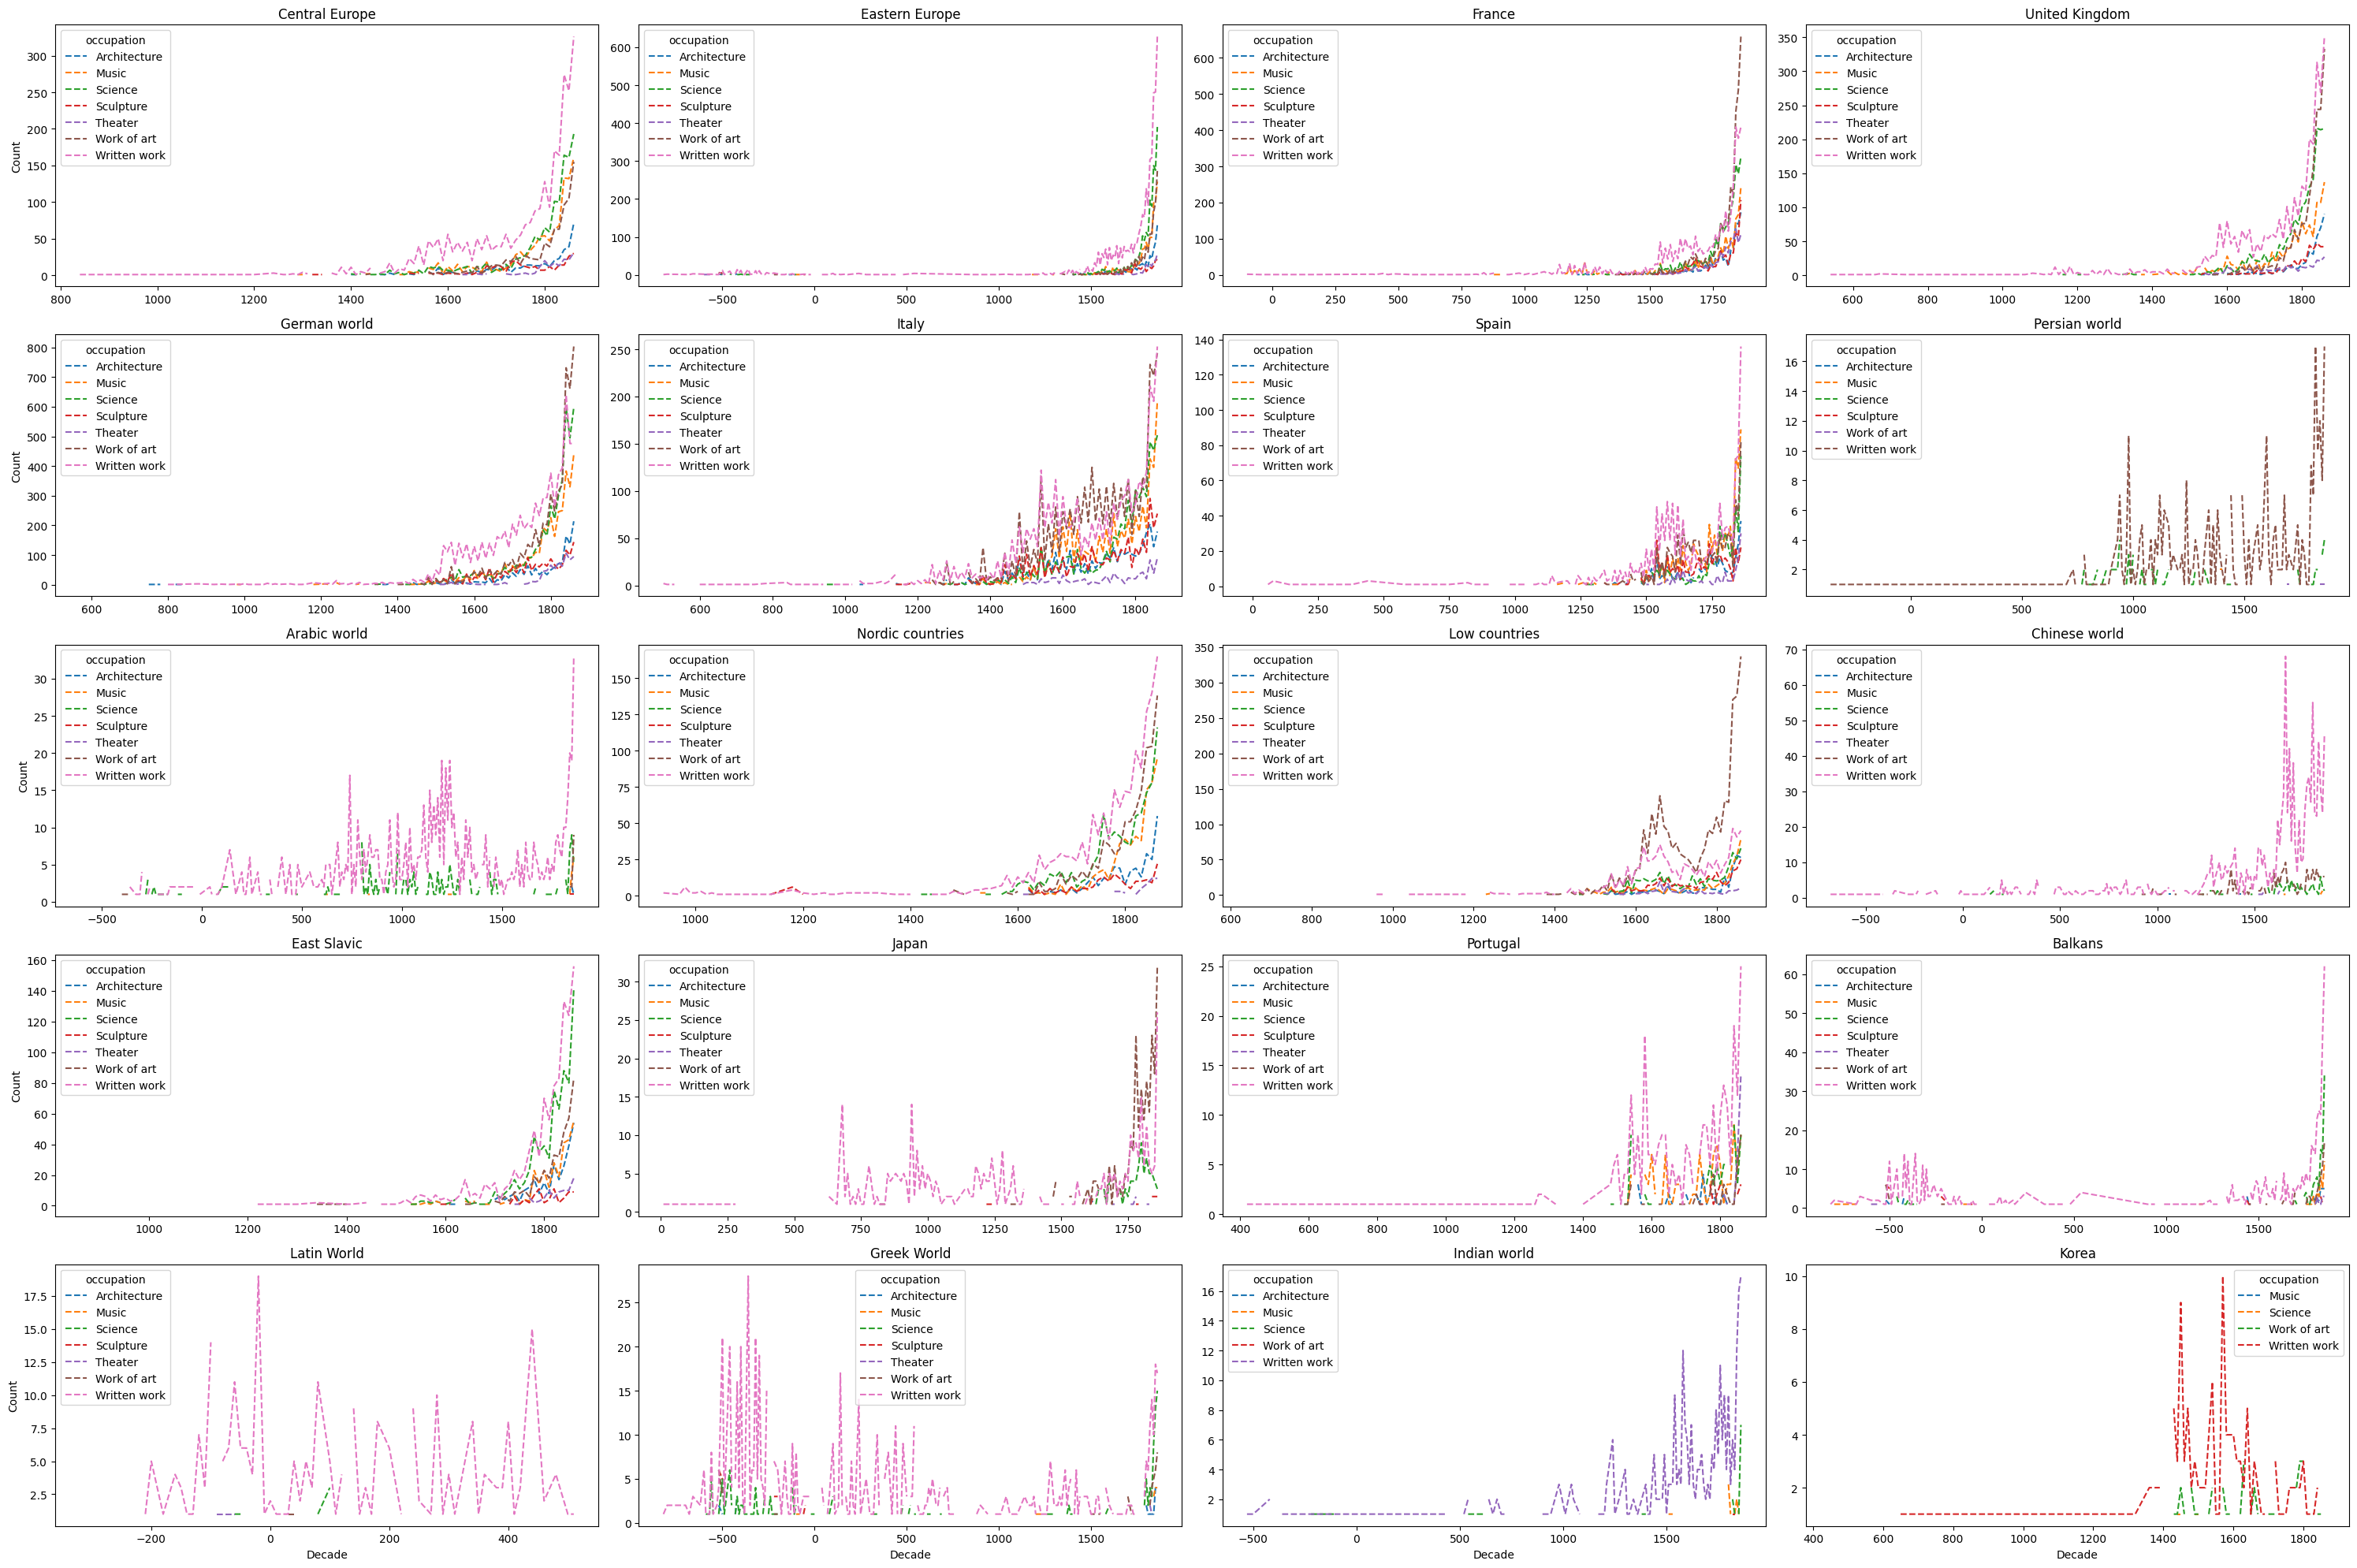

In [27]:
# Get unique regions
unique_regions = df_m["region_name"].unique()

# Calculate number of rows and columns for subplots
num_rows = 5
num_cols = 4

# Calculate total number of subplots needed
num_plots = len(unique_regions)

# Calculate figure size
fig_width = 30  # Adjust this as needed
fig_height = num_rows * 4  # Adjust this as needed

# Create figure and axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Flatten the axes array to easily iterate over them
axs = axs.flatten()

# Iterate over each region
for i, region in enumerate(unique_regions):
    # Get the current axis
    ax = axs[i]
    
    # Filter data for the current region
    region_data = df_m[df_m["region_name"] == region]
    
    # Group by decade and gender, count individual_wikidata_id, and unstack
    grouped_data = region_data.groupby(["decade", "occupation"])["individual_wikidata_id"].count().unstack()
    
    # Plot the data
    grouped_data.plot(ax=ax, ls="--")
    
    # Set title for the subplot
    ax.set_title(region)
    
    # Hide x-axis label for all but the bottom row
    if i // num_cols != num_rows - 1:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Decade')
    
    # Hide y-axis label for all but the leftmost column
    if i % num_cols != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))}

occupation_model = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + occupation + (1|region_name)', 
    df_occupation_sample[['decade','region_name', 'occupation', 'y']], 
    family='bernoulli', 
    priors=priors)

occupation_model_fitted = occupation_model.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True}

)  # important to run faster and sample more efficiently

Modeling the probability that y==1
Compiling...
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:01.987460
Sampling...
sample: 100%|██████████| 2000/2000 [00:51<00:00, 38.95it/s, 63 steps of size 7.17e-02. acc. prob=0.94] 
Sampling time = 0:03:27.241867
Transforming variables...
Transformation time = 0:00:00.236323
Computing Log Likelihood...
Log Likelihood time = 0:00:00.401580


In [183]:
def get_unseen_numbers_occupation(df, model, model_fitted, region = 'Chinese world'):

    new_data = {}

    data = df[df["region_name"] == region]
    new_data["decade"] = data["decade"].values 
    new_data["occupation"] = data["occupation"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)

    new_data = pd.DataFrame(new_data)
    model.predict(model_fitted, data=new_data)
    posterior_stacked = az.extract(occupation_model_fitted)

    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    new_data['f0']=pd.DataFrame(f0).apply(list, axis=1)
    new_data = new_data.sort_values(['decade', 'occupation'])

    def sum_lists(group):
        return [sum(values) for values in zip(*group)]

    res = new_data.groupby(['decade', 'occupation'])['f0'].apply(sum_lists).rename('f0_list').reset_index()
    df_count = data.groupby(['decade', 'occupation'])['individual_wikidata_id'].count().rename('count_cps').reset_index()
    res = pd.merge(res, df_count, on = ['decade', 'occupation'])

    def add_count_cps(row):
        return [x + row['count_cps'] for x in row['f0_list']]

    # Apply the function to each row
    res['N_est_list'] = res.apply(add_count_cps, axis=1)
    res['N_est'] = res['N_est_list'].apply(lambda x : np.mean(x))

    def compute_quantiles(row):
        return np.quantile(row, [0.11, 0.89])

    # Apply the function to each row in the N_est_list column
    res['quantiles'] = res['N_est_list'].apply(compute_quantiles)
    res['lower'] = res['quantiles'].apply(lambda x: x[0])
    res['upper'] = res['quantiles'].apply(lambda x: x[1])

    res = res.drop(['f0_list', 'N_est_list', 'quantiles'], axis=1)
    res['region_name'] = region

    return res

In [185]:
final_table = []
for region in df_occupation_sample.region_name.unique():
    table = get_unseen_numbers_occupation(df_occupation_sample, occupation_model, occupation_model_fitted, region = region)
    final_table.append(table)

df_final_table = pd.concat([x for x in final_table])
df_final_table['model_type'] = 'occupation_model'

,decade,occupation,count_cps,N_est,lower,upper,region_name
0,160,Written work,1,4.887520,2.484044,7.903591,France
1,480,Written work,1,4.825425,2.635330,7.415028,France
2,760,Written work,1,4.722035,2.670323,7.225610,France
3,880,Written work,1,4.544339,2.875910,6.454239,France
4,1000,Written work,1,4.892232,3.008598,7.140800,France
...,...,...,...,...,...,...,...
258,1860,Science,29,334.119473,266.933809,405.468895,France
259,1860,Sculpture,17,116.217375,90.085036,144.615359,France
260,1860,Theater,6,86.977241,57.112123,121.705308,France
261,1860,Work of art,72,373.986231,315.284521,438.146965,France


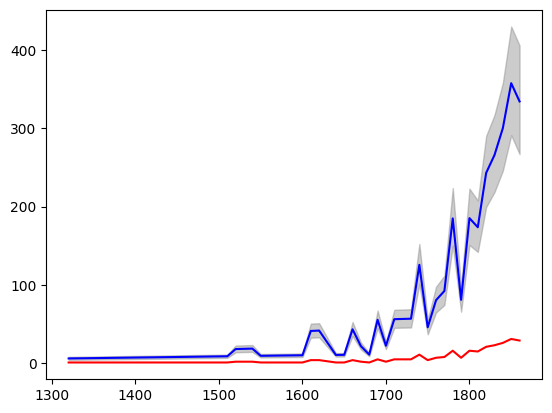

In [187]:
fig, ax = plt.subplots()
data_filtered = res[res['occupation']=='Science']
ax.plot(data_filtered['decade'], data_filtered['N_est'], color='blue')
ax.plot(data_filtered['decade'], data_filtered['count_cps'], color='red')
ax.fill_between(data_filtered['decade'], data_filtered['lower'],  data_filtered['upper'], alpha=0.4, color='grey')
plt.show()

In [188]:
df

,individual_wikidata_id,decade,region_name,count_works,occupation,century,count
0,Q29436295,1660,Low countries,3.0,Work of art,1700,3.0
7,Q18546722,1680,United Kingdom,7.0,Work of art,1700,7.0
8,Q60835032,1820,Central Europe,0.0,Music,1800,0.0
9,Q60835032,1820,Eastern Europe,0.0,Music,1800,0.0
10,Q1100854,1860,Central Europe,0.0,Written work,1900,0.0
...,...,...,...,...,...,...,...
571509,Q26995058,1880,German world,0.0,Sculpture,1900,0.0
571517,Q162038,1860,France,0.0,Work of art,1900,0.0
571518,Q1458059,1800,Central Europe,0.0,Architecture,1800,0.0
571519,Q1458059,1800,Eastern Europe,0.0,Architecture,1800,0.0
